# Recurrent Neural Network

RNN is a type of artificial neural network designed for **sequential data** processing. Unlike traditional neural networks, RNNs have connections that form a directed cycle, allowing them to maintain a memory of **previous inputs** in their internal state. This makes RNNs well-suited for tasks involving sequences, such as natural language processing, speech recognition, and time series prediction.

In the **traditional neural network**, the inputs and the outputs are **independent** of each other, whereas the **output in RNN is dependent on prior elementals within the sequence**. Recurrent networks also **share parameters across each layer of the network**, and during gradient descent, the weights and basis are **adjusted individually to reduce the loss**.

**Summary:** **RNNs have memory.** The memory function in RNNs is facilitated through a **feedback loop** within the cell.

An RNN operates as follows: in each cell, the input of the current time step, denoted as x (representing the present value), is combined with the hidden state h from the previous time step (reflecting past values) and a bias.

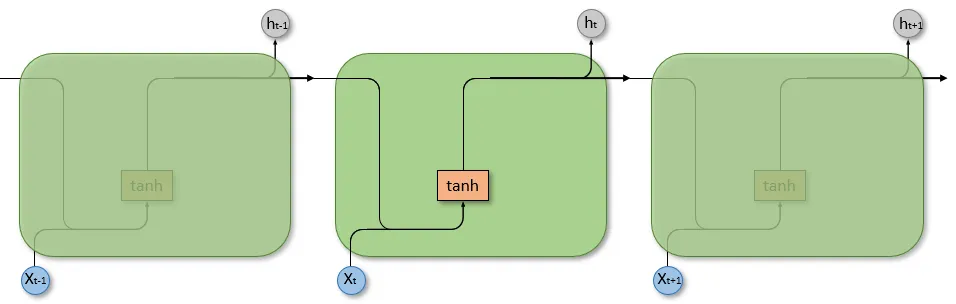

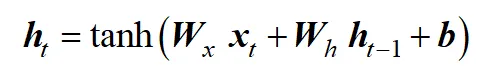

- reference: https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4

The input layer takes the initial input and sends it to the middle layer, which has multiple hidden layers. Each hidden layer has its own activation functions, weights, and biases. These parameters are standardized across the hidden layers, effectively creating a loop over one hidden layer instead of multiple.

Recurrent Neural Networks (RNNs) use **backpropagation through time (BPTT)** instead of traditional backpropagation. In backpropagation, the model adjusts the parameter by calculating errors from the output to the input layer. **BPTT sums the error at each time step as RNN shares parameters across each layer.**

Basic RNN modules consist of a single tanh layer in a repetitive pattern. However, their simplicity leads to a **limitation** known as **short memory**, making it challenging to preserve information from earlier time steps in extensive sequential data. To overcome this issue, advanced architectures like **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** are employed, excelling in retaining information over more extended periods.

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
# import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

set_seed(26)
np.random.seed(26)

In [60]:
# read dataset, convert date column as date format by using parse_dates
dataset = pd.read_csv(
    "MRK.csv", index_col="Date", parse_dates=["Date"]
).drop(["Adj Close", "Volume"], axis=1)
display(dataset.head())

,Open,High,Low,Close
Date,,,,
1970-01-02,1.565972,1.565972,1.541667,1.545139
1970-01-05,1.545139,1.555556,1.531250,1.536458
1970-01-06,1.536458,1.548611,1.527778,1.548611
1970-01-07,1.548611,1.562500,1.531250,1.534722
1970-01-08,1.538194,1.555556,1.538194,1.545139


In [61]:
# analyze the basic statistics of the data set
display(dataset.describe())

,Open,High,Low,Close
count,12676.000000,12676.000000,12676.000000,12676.000000
mean,28.651160,28.950246,28.355220,28.661649
std,25.486185,25.755966,25.218092,25.495462
min,1.029514,1.048611,1.020833,1.029514
25%,2.420139,2.444444,2.398438,2.423611
50%,24.645833,24.937500,24.375000,24.666666
75%,50.000000,50.490002,49.459999,49.954688
max,95.750000,96.687500,93.437500,94.875000


In [62]:
# Find the earliest and latest datapoints
print(dataset.reset_index().Date.min())
print(dataset.reset_index().Date.max())

1970-01-02 00:00:00
2020-04-01 00:00:00


In [63]:
# check if there is any missing values
dataset.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

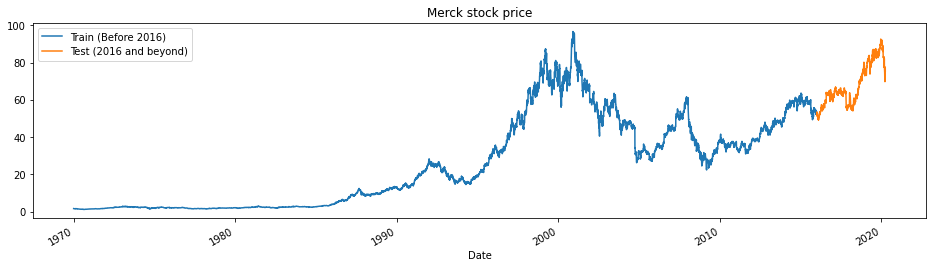

In [64]:
# Split the dataset into testing and training. An important point to note is that, 
# since it is a sequential dataset, random splitting won't work. 
# Therefore, we need to be careful about this. The test set needs to start from the endpoint of the training set.
# Plot trainig and test

tstart = 1970
tend = 2015

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Merck stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Merck Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Merck Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

## Parameters

In [65]:
# set parameters
# how many data points that will be used to predict next one
n_steps = 100
# how many data points will be predicted 
features = features
# epochs
epochs=5
# batch size
batch_size=32

## Data Preprocessing

In [66]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [67]:
# Standardize the training set to avoid the outliers or anomalies. 
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [68]:
# The split_sequence function processes a training dataset, dividing it into two sets: 
# inputs (X_train) and outputs (y_train). 
# As an illustration, if we take the sequence [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] and set n_step to three, 
# the function will generate three input timestamps (1, 2, 3) with a corresponding output of 4.

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = n_steps
features = features
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [69]:
# print(len(X_train)) 
# print(len(X_train[0])) 
# print(len(y_train)) 
# print(len(y_train[0])) 

print((X_train.shape)) 
print((X_train[0].shape)) 
print((y_train.shape)) 
print((y_train[0].shape)) 

(11507, 100, 1)
(100, 1)
(11507, 1)
(1,)


In [70]:
# Reshaping X_train for model
# It reshapes the input data into a structure with 60 timesteps (columns) and 1 feature (output). 
# This reshaping is done to match the input requirements of certain types of neural network models, such as LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

In [71]:
# print(len(X_train)) 
# print(len(X_train[0])) 
# print(len(y_train)) 
# print(len(y_train[0])) 

print((X_train.shape)) 
print((X_train[0].shape)) 
print((y_train.shape)) 
print((y_train[0].shape)) 

(11507, 100, 1)
(100, 1)
(11507, 1)
(1,)


## RNN

In [72]:
# # define parameters
# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

n_outputs = y_train.shape[1]


# # define model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(130, dropout=0.2, return_sequences=True, input_shape=(n_steps, features)))
rnn_model.add(SimpleRNN(110, dropout=0.2, activation="tanh", return_sequences=True))
rnn_model.add(SimpleRNN(130, dropout=0.2, activation="tanh", return_sequences=True))
rnn_model.add(SimpleRNN(100, dropout=0.2, activation="sigmoid", return_sequences=True))
rnn_model.add(SimpleRNN(40, dropout=0.3, activation="tanh"))
rnn_model.add(Dense(n_outputs))

In [73]:
rnn_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

In [75]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[stop_early])


Epoch 1/5
288/288 [==============================] - 32s 111ms/step - loss: 0.0223 - val_loss: 0.0011
Epoch 2/5
288/288 [==============================] - 32s 113ms/step - loss: 0.0125 - val_loss: 0.0141
Epoch 3/5
288/288 [==============================] - 32s 112ms/step - loss: 0.0049 - val_loss: 4.0847e-04
Epoch 4/5
288/288 [==============================] - 32s 111ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 5/5
288/288 [==============================] - 32s 110ms/step - loss: 0.0023 - val_loss: 0.0037


In [78]:
predicted_stock_price = rnn_model.predict(X_test, verbose=0)

34/34 [==============================] - 1s 22ms/step


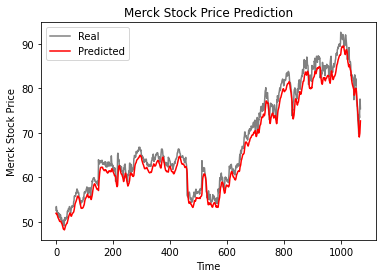

In [79]:
# We're set to repeat the preprocessing and normalization steps for the test set. 
# The sequence involves transforming, splitting into samples, reshaping, predicting, 
# and then reverting the predictions back to their original scale.

dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plot_predictions(test_set,predicted_stock_price)

### Limitations of RNN
Simple RNN models usually run into two major issues. These issues are related to gradient, which is the slope of the loss function along with the error function.

Vanishing Gradient problem occurs when the gradient becomes so small that updating parameters becomes insignificant; eventually the algorithm stops learning.
Exploding Gradient problem occurs when the gradient becomes too large, which makes the model unstable. In this case, larger error gradients accumulate, and the model weights become too large. This issue can cause longer training times and poor model performance.
The simple solution to these issues is to reduce the number of hidden layers within the neural network, which will reduce some complexity in RNNs. These issues can also be solved by using advanced RNN architectures such as LSTM and GRU.


RNN models often face two significant challenges linked to the gradient – the slope of the loss function in relation to the error function.

1 - Vanishing Gradient Problem:
Occurs when the gradient becomes extremely small, rendering parameter updates insignificant.

2 - Exploding Gradient Problem:

Arises when the gradient becomes excessively large, causing model instability.
Results in the accumulation of larger error gradients and oversized model weights.

### Solutions

1 - reduce the number of hidden layers in the neural network

2- use more advanced RNN architectures like LSTM and GRU 

## Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to address the **vanishing gradient problem** and **capture long-term dependencies in sequential data**. LSTMs are particularly useful when dealing with sequences where information from **distant past time steps** is crucial for making predictions.

Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in several sequential problems

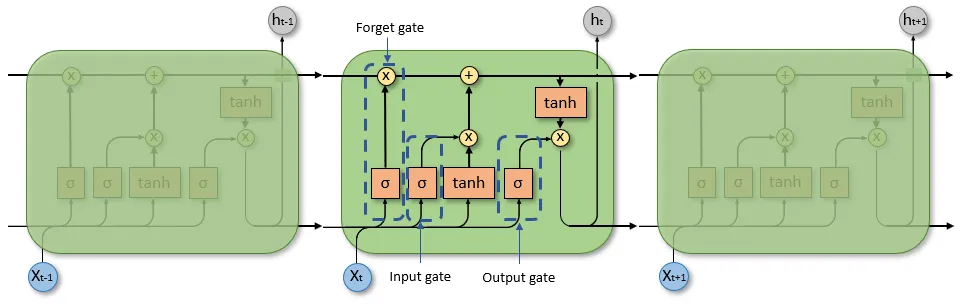
- reference: https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4





Here are key characteristics of LSTM networks:

- Memory Cells and Gates:

LSTMs have memory cells that can store and access information over long sequences. These cells maintain a cell state that can be selectively updated or cleared.

The key to LSTMs is the cell state, which is passed from the input to the output of a cell. Thus, the cell state allows information to flow along the entire chain with only minor linear actions through three gates. Hence, the cell state represents the long-term memory of the LSTM. The three gates are called the forget gate, input gate, and ouput gate. These gates work as filters and control the flow of information and determine which information is kept or disregarded.

LSTMs use three types of gates to control the flow of information: the input gate, the forget gate, and the output gate.

- Input Gate: Regulates the updating of the cell state. A sigmoid layer decides which values are updated

- Forget Gate: Controls which information to discard from the cell state.For this, a sigmoid function is used which states the importance of the cell state.

- Output Gate: Determines the output based on the current cell state. The output gate is responsbile for the short-term memory.


- Long-Term Dependencies:

LSTMs are designed to capture and remember long-term dependencies in sequential data, making them well-suited for tasks where understanding context over extended periods is crucial.


- Gradient Flow:

LSTMs address the vanishing gradient problem by providing a more effective path for the gradient to flow through the network during backpropagation.


- Applications:

LSTMs are commonly used in various tasks such as natural language processing (NLP), speech recognition, time series prediction, and other sequential data tasks.


The architecture of LSTMs enables them to capture and retain information over extended sequences, making them powerful tools for tasks involving sequential data where traditional RNNs may struggle.

LSTMs share similar advantages with RNNs, primarily excelling in capturing both long-term and short-term patterns within a sequence. However, their more intricate structure makes LSTMs computationally more demanding, resulting in extended training times.

In [27]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/5
360/360 [==============================] - 22s 60ms/step - loss: 3.5805e-04
Epoch 2/5
360/360 [==============================] - 21s 59ms/step - loss: 2.3497e-04
Epoch 3/5
360/360 [==============================] - 21s 59ms/step - loss: 1.8270e-04
Epoch 4/5
360/360 [==============================] - 27s 76ms/step - loss: 1.5426e-04
Epoch 5/5
360/360 [==============================] - 29s 80ms/step - loss: 1.3817e-04


In [30]:
# We're set to repeat the preprocessing and normalization steps for the test set. 
# The sequence involves transforming, splitting into samples, reshaping, predicting, 
# and then reverting the predictions back to their original scale.

dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


34/34 [==============================] - 1s 23ms/step


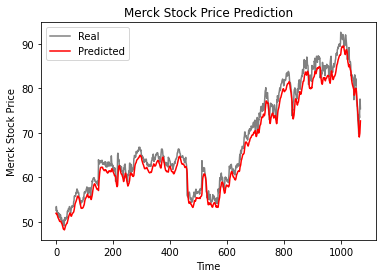

In [32]:
plot_predictions(test_set,predicted_stock_price)

In [33]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.08.


## Gated Recurrent Unit (GRU)

The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture that, like the Long Short-Term Memory (LSTM) network, is designed to address the vanishing gradient problem and capture long-term dependencies in sequential data. GRUs were introduced as a simplified alternative to LSTMs with comparable performance in many tasks.


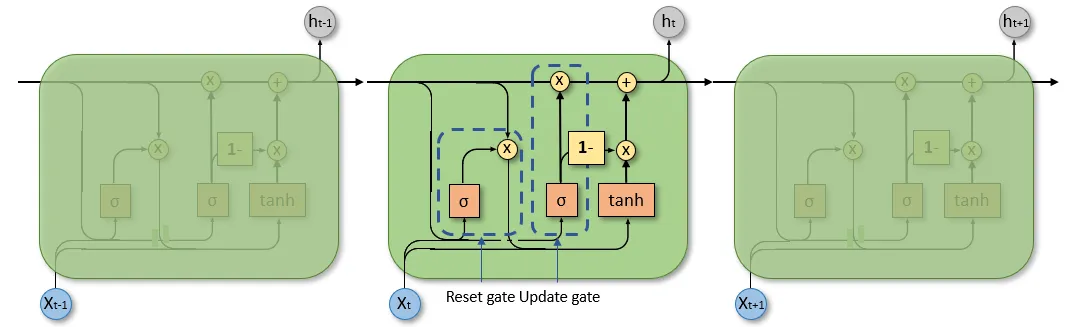

- reference: https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4

The difference to LSTMs, however, is that GRUs use **fewer gates** and do **not have a separate internal memory, i.e., cell state**. Hence, the GRU solely relies on the hidden state as a memory, leading to a **simpler architecture**.


Key features of GRUs include:


- Gating Mechanism:

GRUs have a gating mechanism similar to LSTMs, but with a somewhat simpler structure.
They typically include two gates: the reset gate and the update gate.
Reset Gate:

The reset gate determines how much of the past information should be forgotten or reset. It decides which parts of the previous state should be ignored.

The reset gate plays a crucial role in managing short-term memory by determining the extent to which past information is retained or discarded.

The update gate, in contrast, is responsible for the long-term memory and is comparable to the LSTM’s forget gate.The update gate regulates how much of the new candidate values should be blended with the previous state.


- Hidden State:

GRUs maintain a hidden state that captures information from previous time steps.

- Candidate State: 

The candidate state is a combination of the current input and the hidden state of the previous time step and an activation function.


Simplified Structure:
Compared to LSTMs, GRUs have a more straightforward architecture with fewer parameters.

- Memory Efficiency:

GRUs can be computationally more efficient than LSTMs due to their simpler structure, making them suitable for certain applications.

- Applications:

GRUs are commonly used in natural language processing (NLP), speech recognition, and other sequential data tasks.
GRUs and LSTMs share the goal of addressing the challenges associated with learning long-term dependencies in sequential data. The choice between GRU and LSTM often depends on the specific requirements of the task, and both architectures have been successful in various applications.

GRUs are computationally more efficent and faster to train as they need less memory. Moreover, GRUs haven proven to be more efficient for smaller sequences.As GRUs do not have a separate hidden and cell state they might not be able to consider observations as far into the past as the LSTM.

In [34]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/5
360/360 [==============================] - 19s 52ms/step - loss: 4.8533e-04
Epoch 2/5
360/360 [==============================] - 19s 53ms/step - loss: 2.6901e-04
Epoch 3/5
360/360 [==============================] - 19s 53ms/step - loss: 2.1343e-04
Epoch 4/5
360/360 [==============================] - 19s 52ms/step - loss: 1.7731e-04
Epoch 5/5
360/360 [==============================] - 19s 52ms/step - loss: 1.5609e-04


34/34 [==============================] - 1s 17ms/step


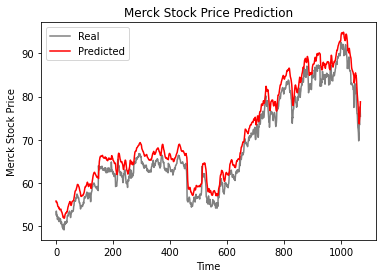

In [37]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [38]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 2.86.


### References 

- Dataset: 

https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?select=symbols_valid_meta.csv

- https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network
- https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4